In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# Section 1: Data Loading and Preprocessing
# -----------------------------------------
# Load the stock data from a CSV file into a pandas DataFrame
data = pd.read_csv(r'D:\CurrentWork\NvidiaStockPrediction\nvidia_stock_prices.csv')

# Convert 'Date' column to datetime format and set it as the DataFrame index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Keep only the 'Close' column, as we are predicting based on closing prices
data = data[['Close']]

# Initialize a MinMaxScaler to scale the data to the range (0, 1) for better model performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [3]:
# Section 2: Create Training Dataset
# ----------------------------------
# We use the first 80% of the data for training
train_data = scaled_data[0:int(len(scaled_data) * 0.8)]

# Create X_train and y_train with a 60-day look-back period (60 time steps)
X_train = []
y_train = []

for i in range(60, len(train_data)):
    # X_train stores 60-day window of stock prices
    X_train.append(train_data[i - 60:i, 0])
    # y_train stores the stock price at the 61st day
    y_train.append(train_data[i, 0])

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM input to be of shape [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [4]:
# Section 3: Build the LSTM Model
# -------------------------------
# Initialize the Sequential model
model = Sequential()

# Add the first LSTM layer with 50 units and return_sequences=True (since we have another LSTM layer)
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))  # Add dropout for regularization (to avoid overfitting)

# Add the second LSTM layer with 50 units
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))  # Add dropout again for regularization

# Add the output layer (Dense layer) with 1 unit (predicting a single value)
model.add(Dense(units=1))

In [5]:
# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# Train the model on the training data for 5 epochs, using a batch size of 32
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
124/124 [==============================] - 5s 12ms/step - loss: 7.9263e-05
Epoch 2/20
124/124 [==============================] - 1s 11ms/step - loss: 2.1465e-05
Epoch 3/20
124/124 [==============================] - 1s 12ms/step - loss: 1.7144e-05
Epoch 4/20
124/124 [==============================] - 1s 11ms/step - loss: 1.6922e-05
Epoch 5/20
124/124 [==============================] - 1s 12ms/step - loss: 1.5340e-05
Epoch 6/20
124/124 [==============================] - 1s 12ms/step - loss: 1.2762e-05
Epoch 7/20
124/124 [==============================] - 1s 11ms/step - loss: 1.4345e-05
Epoch 8/20
124/124 [==============================] - 1s 12ms/step - loss: 1.3971e-05
Epoch 9/20
124/124 [==============================] - 1s 11ms/step - loss: 1.3603e-05
Epoch 10/20
124/124 [==============================] - 1s 11ms/step - loss: 1.8807e-05
Epoch 11/20
124/124 [==============================] - 1s 11ms/step - loss: 1.2121e-05
Epoch 12/20
124/124 [==============================]

In [7]:
# Section 4: Prepare the Test Data
# --------------------------------
# Use the remaining 20% of the data for testing
test_data = scaled_data[int(len(scaled_data) * 0.8):]

# Prepare the test inputs: reshape the test data and create the X_test data with a 60-day look-back
inputs = test_data.reshape(-1, 1)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i - 60:i, 0])

# Convert X_test into a numpy array and reshape it for the LSTM input
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
# Section 5: Make Predictions
# ---------------------------
# Use the trained model to predict the stock prices on X_test data
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original stock price scale
predictions = scaler.inverse_transform(predictions)

30/30 [==============================] - 1s 6ms/step


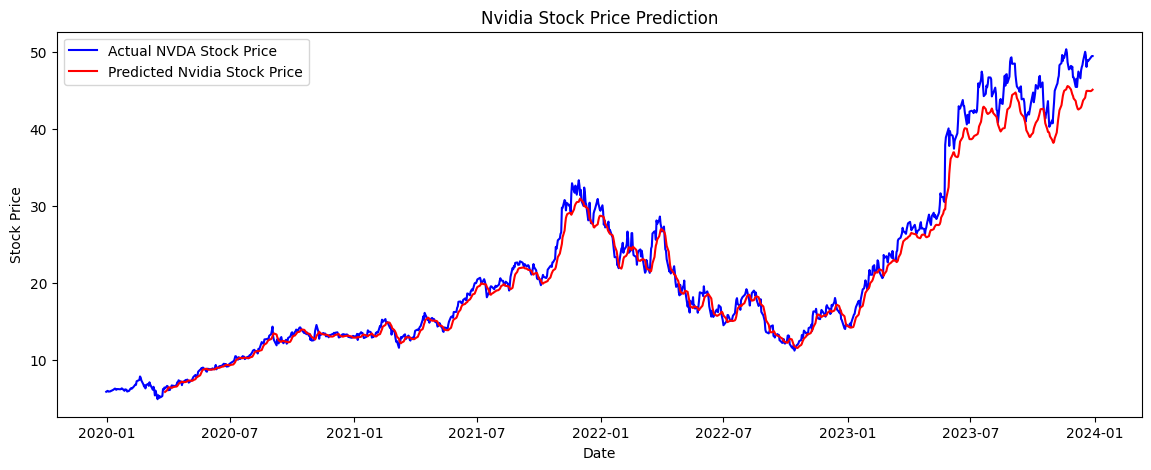

In [9]:
# Section 6: Plotting the Results
# -------------------------------
# Since we have a 60-day look-back period, we need to adjust the dates accordingly
predicted_dates = data.index[int(len(data) * 0.8) + 60: int(len(data) * 0.8) + 60 + len(predictions)]

# Plot actual vs predicted stock prices
plt.figure(figsize=(14, 5))
plt.plot(data.index[int(len(data) * 0.8):], data['Close'][int(len(data) * 0.8):], color='blue', label='Actual NVDA Stock Price')
plt.plot(predicted_dates, predictions, color='red', label='Predicted Nvidia Stock Price')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Actual values from the test set (skip the first 60 days due to lookback)
y_true = data['Close'][int(len(data) * 0.8) + 60:].values

# Predicted values (already computed and reshaped)
y_pred = predictions.reshape(-1)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# R-squared (R²)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 3.399395413605312
Root Mean Squared Error (RMSE): 1.843744942665691
Mean Absolute Error (MAE): 1.2186561350765386
R-squared (R²): 0.9742695207142454
